In [1]:
import pandas as pd

df = pd.read_json('datasets/bbc.json')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
id      200 non-null int64
text    200 non-null object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [2]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

In [3]:
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

stopwords = sw.words('english')
def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

In [4]:
def cab_tokenizer(document):
    tokens = []

    for sent in sent_tokenize(document):
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
        
            if token in stopwords:
                continue
            if all(char in punct for char in token):
                continue
            lemma = lemmatize(token, tag)
            tokens.append(lemma)

    return tokens

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer
    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['text'])

    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
        'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
        'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
        for t in count_vec.vocabulary_]

    return terms

terms = calculate_tf_idf_terms(df['text'])

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['text'])
# see the number of unique tokens produced by the vectorizer. Lots of them...
print(len(tfidf_vec.get_feature_names()))
print(tfidf_vec.idf_)

36385
[2.83756901 5.20469262 5.61015773 ... 3.73835555 3.73835555 3.73835555]


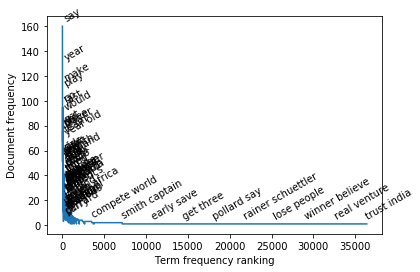

In [7]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 1):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)

    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)] #only grabs 1 term as iter of 50
    labels = [term['term'] for term in sel_terms]

    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')

    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])

    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)

        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y

    plt.show()

visualise_zipf(terms)
#

In [58]:
# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 2 documents and max 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2,max_df=0.7)
X_filter = filter_vec.fit_transform(df['text'])
# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

6922


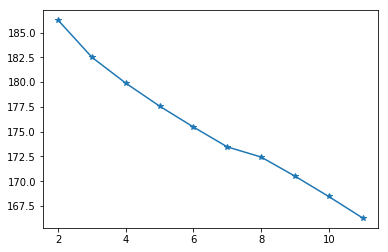

In [59]:
from sklearn.cluster import KMeans
## Test using elbow to find optimal K
clusters = []
inertia_vals = []
for k in range(2, 12, 1):
    model = KMeans(n_clusters=k, random_state=42, n_jobs=10)
    model.fit(X_filter)

    clusters.append(model)
    inertia_vals.append(model.inertia_)

plt.plot(range(2,12,1), inertia_vals, marker='*')
plt.show()

In [60]:
from sklearn.metrics import silhouette_score
for i in range(1,10):
    print("Silhouette score for k=" + str(i+2), silhouette_score(X_filter, clusters[i].predict(X_filter)), '\n')

Silhouette score for k=3 0.020738506215931592 

Silhouette score for k=4 0.022939479373612123 

Silhouette score for k=5 0.02463905454257003 

Silhouette score for k=6 0.02649959338121322 

Silhouette score for k=7 0.027447301492023516 

Silhouette score for k=8 0.026416156836242946 

Silhouette score for k=9 0.027295881003855965 

Silhouette score for k=10 0.02943185261462743 

Silhouette score for k=11 0.032076178741664484 



In [56]:
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.

    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]

    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()

In [61]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=7, random_state=rs).fit(X_filter)
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names())


Top terms for cluster 0: 6, roddick, 7, open, final, 
Top terms for cluster 1: kenteris, greek, thanou, iaaf, test, 
Top terms for cluster 2: wicket, south, south africa, africa, test, 
Top terms for cluster 3: liverpool, club, gerrard, league, chelsea, 
Top terms for cluster 4: holmes, athletics, olympic, britain, conte, 
Top terms for cluster 5: radcliffe, marathon, chepkemei, race, cross country, 
Top terms for cluster 6: england, cup, play, game, player, 
Wall time: 874 ms


In [74]:
z = 

36385

In [79]:
terms = [{'term': t, 'idx': filter_vec.vocabulary_[t],
        'tf': X_filter[:, filter_vec.vocabulary_[t]].sum(),
        'df': X_filter[:, filter_vec.vocabulary_[t]].count_nonzero()}
        for t in filter_vec.vocabulary_]

In [82]:
from operator import itemgetter
newlist = sorted(terms, key=itemgetter('tf')) 

In [85]:
print(newlist)

[{'term': 'seat', 'idx': 5294, 'tf': 0.040620837671106094, 'df': 2}, {'term': '1900', 'idx': 90, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'exclusively', 'idx': 2118, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'constantly', 'idx': 1420, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'hansen', 'idx': 2833, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'oversee', 'idx': 4344, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'arrival', 'idx': 607, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'managing', 'idx': 3773, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'sincerely', 'idx': 5520, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'affirm', 'idx': 395, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'dearly', 'idx': 1674, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'myth', 'idx': 4062, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'reality', 'idx': 4825, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'food', 'idx': 2410, 'tf': 0.044288777705783704, 'df': 2}, {'term': 'hist

In [96]:
print(newlist[-15:])

[{'term': 'final', 'idx': 2274, 'tf': 3.9013184282034024, 'df': 82}, {'term': 'player', 'idx': 4545, 'tf': 3.916341414425308, 'df': 75}, {'term': 'match', 'idx': 3832, 'tf': 3.9608765047504115, 'df': 78}, {'term': 'would', 'idx': 6797, 'tf': 4.011848752190883, 'df': 89}, {'term': 'get', 'idx': 2602, 'tf': 4.036652724001483, 'df': 79}, {'term': 'cup', 'idx': 1562, 'tf': 4.258518589502316, 'df': 67}, {'term': 'take', 'idx': 5939, 'tf': 4.416184805785434, 'df': 108}, {'term': '6', 'idx': 269, 'tf': 4.429290523224101, 'df': 37}, {'term': 'world', 'idx': 6772, 'tf': 4.440925644968059, 'df': 90}, {'term': 'first', 'idx': 2324, 'tf': 4.510273629944291, 'df': 102}, {'term': 'game', 'idx': 2530, 'tf': 4.770521007604352, 'df': 105}, {'term': 'england', 'idx': 2003, 'tf': 4.926661649363099, 'df': 51}, {'term': 'win', 'idx': 6686, 'tf': 5.089456956511561, 'df': 102}, {'term': 'play', 'idx': 4507, 'tf': 5.290030213786883, 'df': 108}, {'term': 'year', 'idx': 6847, 'tf': 5.673905218048171, 'df': 129}

In [95]:
print(X_filter)

  (0, 3755)	0.02654751197075102
  (0, 6467)	0.0407935750057623
  (0, 5802)	0.04706103964367389
  (0, 1562)	0.037683555954444614
  (0, 6686)	0.030174660927723182
  (0, 6596)	0.03712734321798811
  (0, 5054)	0.29709493690015787
  (0, 3714)	0.02849901119638774
  (0, 4973)	0.07454140842844974
  (0, 2096)	0.3545976453236691
  (0, 3775)	0.08713621828309662
  (0, 6426)	0.14469867681987236
  (0, 1553)	0.04445980679353648
  (0, 2157)	0.03313227373138497
  (0, 4752)	0.02990720456705649
  (0, 2274)	0.017039401868100757
  (0, 4843)	0.03037100059444026
  (0, 4850)	0.04445980679353648
  (0, 2701)	0.11013958541310087
  (0, 2806)	0.04360948133846692
  (0, 2441)	0.2039678750288115
  (0, 1532)	0.04244213384287969
  (0, 5050)	0.275798168585076
  (0, 4371)	0.06384975503542656
  (0, 2877)	0.05248194555856461
  :	:
  (199, 5944)	0.064056204376567
  (199, 3085)	0.05776927199657748
  (199, 4351)	0.05776927199657748
  (199, 960)	0.1441962490763271
  (199, 6641)	0.05776927199657748
  (199, 4261)	0.10725635100609